In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime

from sqlalchemy import create_engine

engine = create_engine('sqlite:///data/deploys.db')
df = pd.read_sql('''
SELECT
    *
FROM deploys
''', engine)

def parse_timestamp(timestamp):
    if '.' in timestamp:
        timestamp = timestamp[:-5] + 'Z'  # Remove milliseconds part
    return datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%SZ")
    
# Convert 'type' column to datetime format
df['datetime'] = df['timestamp'].apply(parse_timestamp)

# Extract year from the 'type' column and create a new 'year' column
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')


# Makes your data 538% better...I think
plt.style.use('fivethirtyeight')
df.head()

id        type                 timestamp  duration   user  host  \
0   1  sync_world  2014-02-19T21:31:37.000Z      3126  bd808  None   
1   2  sync_world  2014-02-19T21:41:54.000Z       292  bd808  None   
2   3  sync_world  2014-02-20T21:08:47.000Z      3506  bd808  None   
3   4  sync_world  2014-02-21T00:05:52.000Z      2363  reedy  None   
4   5  sync_world  2014-02-21T18:54:44.000Z       818  bd808  None   

                                             message patchset task sync_path  \
0  no-diff scap to test script changes (duration:...       []   []      None   
1  no-diff scap to test script changes (duration:...       []   []      None   
2  testwiki to 1.23wmf15 and build l10n cache (ta...       []   []      None   
3           no op scap is no op? (duration: 39m 23s)       []   []      None   
4  no-diff scap to test script changes; expect l1...       []   []      None   

  scap3_repo scap3_revision scap3_group            datetime  year  month  day  
0       None           None        None 2014-02-19 21:31:37  2014      2   19  
1       None           None        None 2014-02-19 21:41:54  2014      2   19  
2       None           None        None 2014-02-20 21:08:47  2014      2   20  
3       None           None        None 2014-02-21 00:05:52  2014      2   21  
4       None           None        None 2014-02-21 18:54:44  2014      2   21

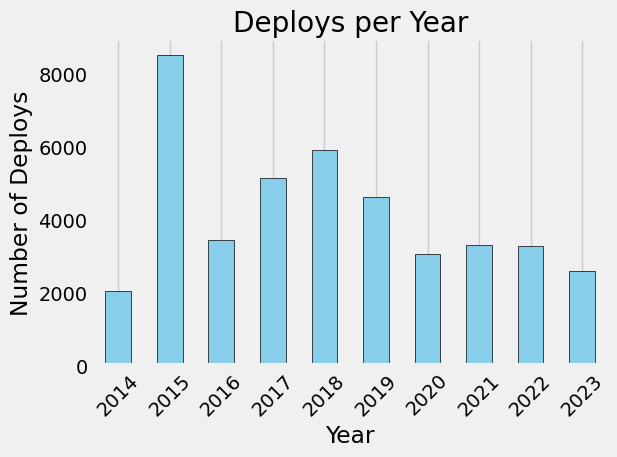

In [3]:
deploys_per_year = df['year'].value_counts().sort_index()

# Plotting the histogram
deploys_per_year.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Year')
plt.ylabel('Number of Deploys')
plt.title('Deploys per Year')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.grid(axis='y')  # Add gridlines on the y-axis

plt.tight_layout()
plt.show()

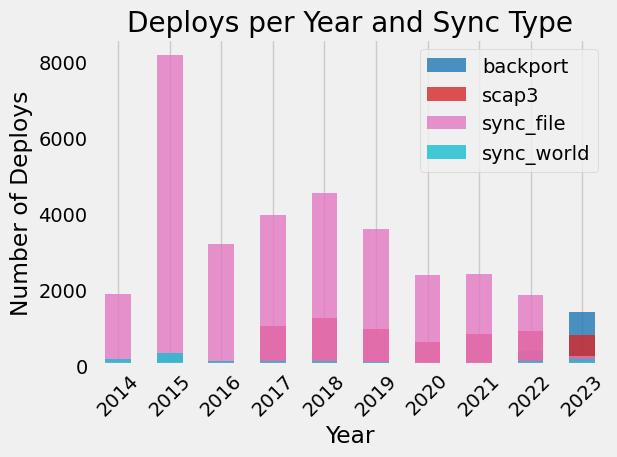

In [5]:
import numpy as np
grouped = df.groupby([df['year'], 'type']).size().unstack().fillna(0)

num_sync_types = len(grouped.columns)
colors = plt.cm.tab10(np.linspace(0, 1, num_sync_types))  # Using a colormap for distinct colors

for i, sync_type in enumerate(grouped.columns):
    grouped[sync_type].plot(kind='bar', color=colors[i % num_sync_types], label=sync_type, alpha=0.8)

plt.xlabel('Year')
plt.ylabel('Number of Deploys')
plt.title('Deploys per Year and Sync Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.legend()
plt.grid(axis='y')  # Add gridlines on the y-axis

plt.tight_layout()
plt.show()

In [9]:
top_user_per_year = df.groupby(df['year'])['user'].apply(lambda x: x.value_counts().nlargest(10))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(top_user_per_year)

year                       
2014  reedy                     315
      maxsem                    257
      springle                  159
      ori                       150
      demon                     149
      manybubbles               136
      yurik                      93
      anomie                     91
      catrope                    72
      awight                     71
2015  krenair                  1372
      l10nupdate                996
      ori                       942
      catrope                   580
      thcipriani                506
      demon                     430
      jynus                     390
      legoktm                   348
      ebernhardson              318
      aude                      264
2016  thcipriani                596
      dereckson                 327
      jynus                     216
      maxsem                    213
      demon                     191
      krenair                   178
      catrope                   177


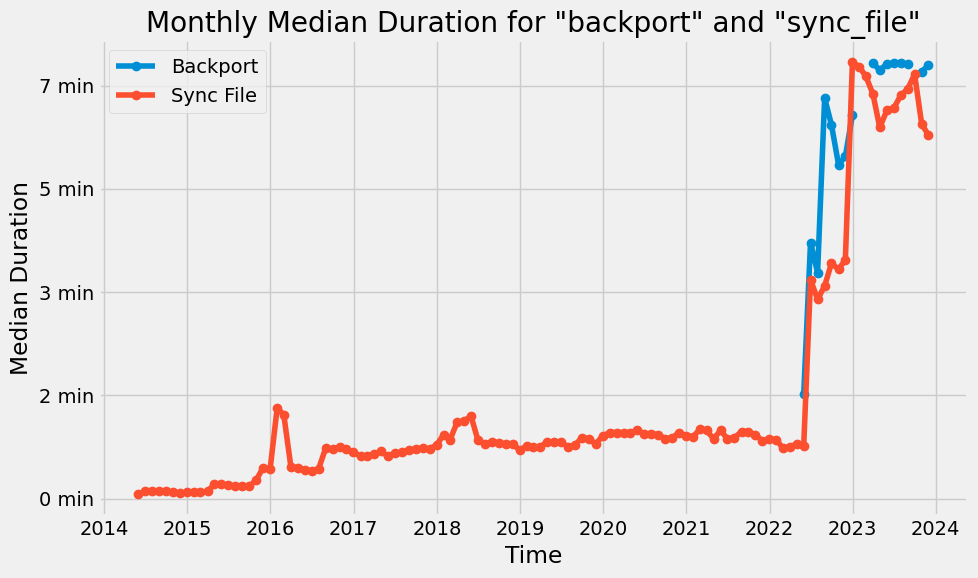

In [48]:
import matplotlib.ticker as ticker

# Assuming df is your DataFrame containing 'datetime', 'sync_type', and 'duration' columns

# Assuming 'duration' column is in numeric format
# Filter the DataFrame for specific sync_types
filtered_df = df[df['sync_type'].isin(['backport', 'sync_file'])]

# Calculate the 95th percentile for 'duration'
duration_95th_percentile = filtered_df['duration'].quantile(0.95)

# Filter the DataFrame based on percentile criteria (discard durations > 95th percentile)
filtered_df = filtered_df[filtered_df['duration'] <= duration_95th_percentile]

# Set 'datetime' as the DataFrame index
filtered_df.set_index('datetime', inplace=True)

# Separate data for each sync_type
backport_data = filtered_df[filtered_df['sync_type'] == 'backport']
sync_file_data = filtered_df[filtered_df['sync_type'] == 'sync_file']

# Resample the data for monthly median duration for each sync_type
backport_monthly_median = backport_data['duration'].resample('M').median()
sync_file_monthly_median = sync_file_data['duration'].resample('M').median()

# Plotting the monthly median duration for each sync_type as distinct lines
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

plt.plot(backport_monthly_median.index, backport_monthly_median.values, marker='o', linestyle='-', label='Backport')
plt.plot(sync_file_monthly_median.index, sync_file_monthly_median.values, marker='o', linestyle='-', label='Sync File')

plt.xlabel('Time')
plt.ylabel('Median Duration')
plt.title('Monthly Median Duration for "backport" and "sync_file"')
plt.xticks()  # Rotate x-axis labels for better readability if needed
plt.legend()
plt.grid(True)

# Function to convert seconds to minutes and format the y-axis tick labels
def format_minutes(x, pos):
    return f'{x/60:.0f} min'  # Convert seconds to minutes and format as 'X min'

# Apply the custom formatting function to the y-axis ticks
formatter = ticker.FuncFormatter(format_minutes)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('monthly-median-sync-durations.png', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
df = pd.read_sql('''
select
  strftime('%Y', datetime(timestamp)) as year,
  strftime('%H', datetime(timestamp)) as hour,
  sum(json_array_length(patchset)) as patches_deployed
from
  deploys
where
  type IN ('backport', 'sync_file') and year = '2023'
group by hour;
''', engine)

df.head()


year hour  patches_deployed
0  2023   00                11
1  2023   01                 8
2  2023   02                 1
3  2023   03                 3
4  2023   04                 3

<Figure size 1000x600 with 0 Axes>

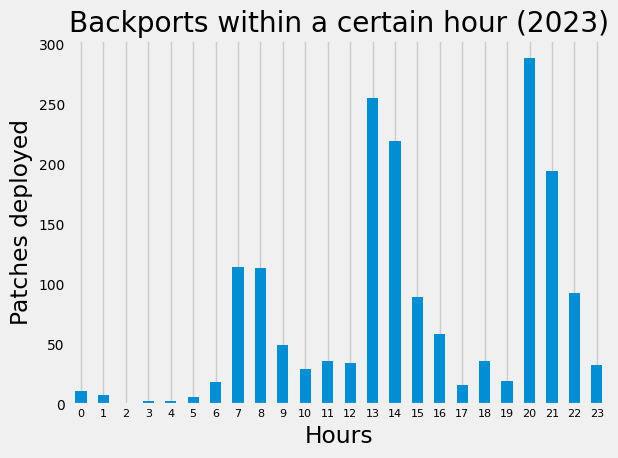

In [20]:
plt.figure(figsize=(10, 6))
df.plot(kind='bar')
plt.xlabel('Hours')
plt.ylabel('Patches deployed')
plt.title('Backports within a certain hour (2023)')
plt.xticks(rotation=0,fontsize=8)
plt.yticks(fontsize=10)
plt.grid(axis='y')
plt.legend().set_visible(False)

plt.tight_layout()
plt.show()